In [ ]:
!pip install hsemotion
!pip install opencv-python
!pip install deepface
!pip install fer

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached n

In [ ]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from hsemotion.facial_emotions import HSEmotionRecognizer
import torch
from tqdm import tqdm
import time
from deepface import DeepFace
from torchvision.datasets import ImageFolder
import random
from fer import FER

In [ ]:
!unzip dataset.zip
!rm dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/anger/images - 2020-11-06T004738.914_face.png  
  inflating: dataset/anger/images - 2020-11-06T004739.991_face.png  
 extracting: dataset/anger/images - 2020-11-06T004743.158_face.png  
 extracting: dataset/anger/images - 2020-11-06T004754.760_face.png  
  inflating: dataset/anger/images - 2020-11-06T004756.249_face.png  
  inflating: dataset/anger/images - 2020-11-06T004757.606_face.png  
  inflating: dataset/anger/images - 2020-11-06T004759.026_face.png  
  inflating: dataset/anger/images - 2020-11-06T004759.426_face.png  
  inflating: dataset/anger/images - 2020-11-06T005255.788_face.png  
 extracting: dataset/anger/images - 2020-11-06T005256.249_face.png  
  inflating: dataset/anger/images - 2020-11-06T005257.204_face.png  
 extracting: dataset/anger/images - 2020-11-06T005258.492_face.png  
  inflating: dataset/anger/images - 2020-11-06T005259.865_face.png  
  inflating: dataset/anger/images -

In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

# Обработка изображений

In [ ]:
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

In [ ]:
meta_df = pd.read_csv('metadata_processed.csv')
face_df = pd.read_csv('icml_face_data.csv')
face_df.columns = ['label', 'Usage', 'pixels']

In [ ]:
face_df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
face_df = face_df[face_df['Usage'] != 'Training']
face_df

,label,Usage,pixels
28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [ ]:
face_df = face_df.rename(columns={"emotion":"label"})
face_df['emotion'] = face_df['label'].apply(lambda x: emotions[int(x)])

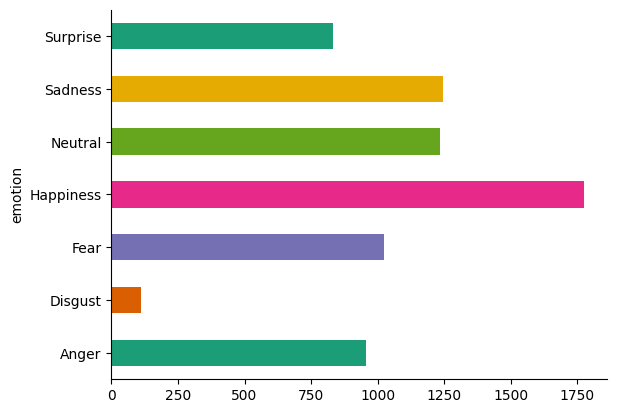

In [ ]:
# @title emotion

from matplotlib import pyplot as plt
import seaborn as sns
face_df.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
face_df.reset_index(drop=True, inplace=True)

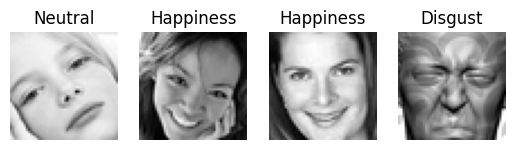

In [ ]:
for _ in range(4):
    id = random.randint(0, 7178)  # Random index
    image = np.reshape(np.array(face_df.pixels[id].split(' ')).astype(int), (48, 48))

    plt.subplot(1, 4, _ + 1)
    plt.imshow(image, cmap='gray')
    plt.title(face_df.emotion[id])
    plt.axis('off')

plt.show()

In [ ]:
def image_transform(image):
    face_img= np.reshape(np.array(image.split(' ')).astype(np.uint8),(48,48))
    return cv2.cvtColor(face_img, cv2.COLOR_GRAY2RGB)

In [ ]:
def calculate_accuracy(actual, predict):
    correct = sum(1 for x, y in zip(actual, predict) if x == y)
    total = len(actual)
    accuracy = correct / total * 100
    return accuracy

In [ ]:
face_img_list=[]
for img in face_df.pixels:
    face_img_list.append(image_transform(img))

In [ ]:
def confusion_count(predicted_emotions, actual_emotions):
    confusion_count = {}

    for predicted, actual in zip(predicted_emotions, actual_emotions):
        if predicted != actual:
            key = (predicted, actual)
            confusion_count[key] = confusion_count.get(key, 0) + 1

    return confusion_count

In [ ]:
def confusion_diagramm(confusion_count):
    emotions_pairs = list(confusion_count.keys())
    errors_count = list(confusion_count.values())

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(emotions_pairs)), errors_count, color='skyblue')
    plt.yticks(range(len(emotions_pairs)), [f'{pair[0]} -> {pair[1]}' for pair in emotions_pairs])
    plt.ylabel('Пары эмоций')
    plt.xlabel('Количество ошибок')
    plt.title('Частота некорректного определения эмоций моделью')
    plt.show()

# Точность моделей HSEmotion


In [ ]:
models = ['enet_b2_7', 'enet_b0_8_best_vgaf','enet_b0_8_best_afew']
result = {}

In [ ]:
actual = face_df['emotion'].tolist()

In [ ]:
def get_emotion(id):
  face_img = image_transform(face_df.pixels[id])
  emotion,scores=fer.predict_emotions(face_img,logits=True)
  return emotion

/root/.hsemotion/enet_b2_7.pt Compose(
    Resize(size=(260, 260), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
enet_b2_7
Время выполнения: 281.46418046951294 секунд
Accuracy: 57.45332961827807


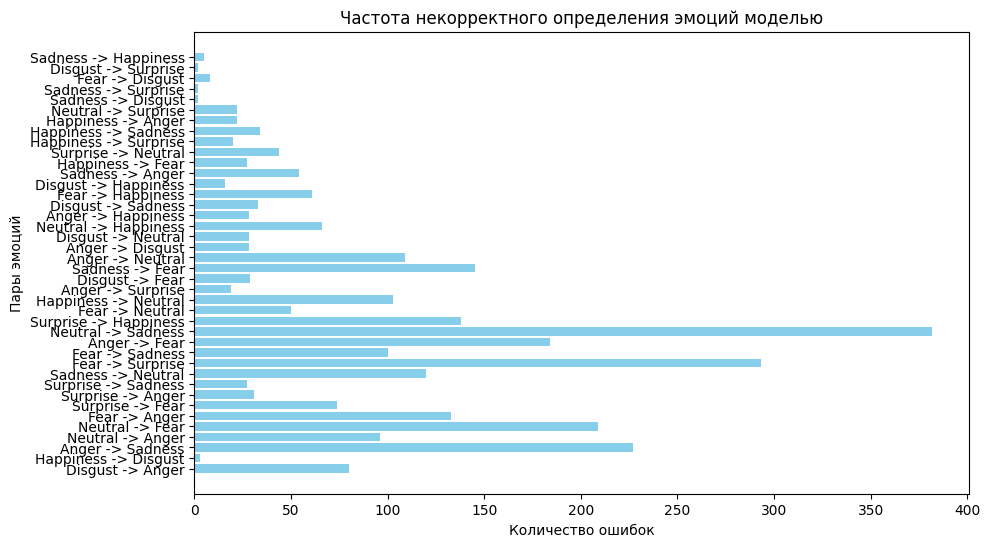

/root/.hsemotion/enet_b0_8_best_vgaf.pt Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
enet_b0_8_best_vgaf
Время выполнения: 199.6245038509369 секунд
Accuracy: 53.259960991919755


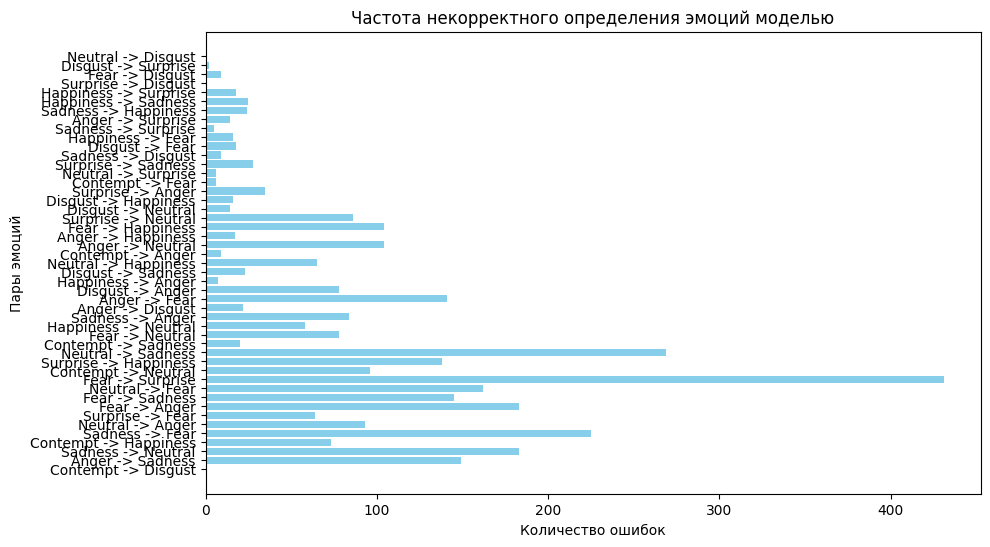

/root/.hsemotion/enet_b0_8_best_afew.pt Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
enet_b0_8_best_afew
Время выполнения: 206.94991421699524 секунд
Accuracy: 55.46113123432711


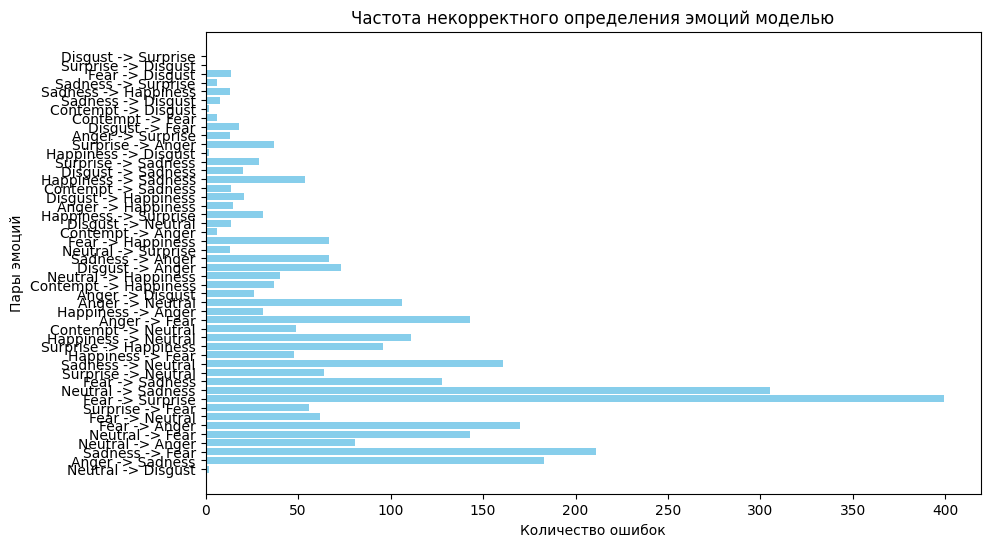

In [ ]:
for model in models:
    fer=HSEmotionRecognizer(model_name=model, device=device)
    prediction = []
    start_time = time.time()
    for img in face_img_list:
      emotion,scores=fer.predict_emotions(img,logits=False)
      prediction.append(emotion)
    end_time = time.time()
    execution_time = end_time - start_time
    result[model] = {}
    result[model]['time'] = execution_time
    accuracy = calculate_accuracy(prediction, actual)
    result[model]['accuracy'] = accuracy
    print(model)
    print(f"Время выполнения: {execution_time} секунд")
    print(f"Accuracy: {accuracy}")
    confusion_diagramm(confusion_count(prediction, actual))

# Точность моделей DeepFace


In [ ]:
result['deepFace'] = {}

In [ ]:
deepface_emotions = []
start_time = time.time()
for img in face_img_list:
    demography = DeepFace.analyze(img_path = img, enforce_detection = False, actions=['emotion'])
    deepface_emotions.append(demography[0]['dominant_emotion'])
end_time = time.time()
execution_time = end_time - start_time
result['deepFace']['time'] = execution_time
print("Время выполнения: %s секунд" % execution_time)

24-04-10 14:02:46 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 86.2MB/s]


Время выполнения: 579.0083310604095 секунд


In [ ]:
word_map = {
    'happy': 'Happiness',
    'angry': 'Anger',
    'sad': 'Sadness',
    'fear': 'Fear',
    'neutral': 'Neutral',
    'surprise': 'Surprise',
    'disgust': 'Disgust'
}

In [ ]:
deepface_emotions = [word_map.get(word, word) for word in deepface_emotions]
result['deepFace']['accuracy'] = calculate_accuracy(deepface_emotions, actual)

In [ ]:
result['deepFace']['accuracy']

55.8233491223182

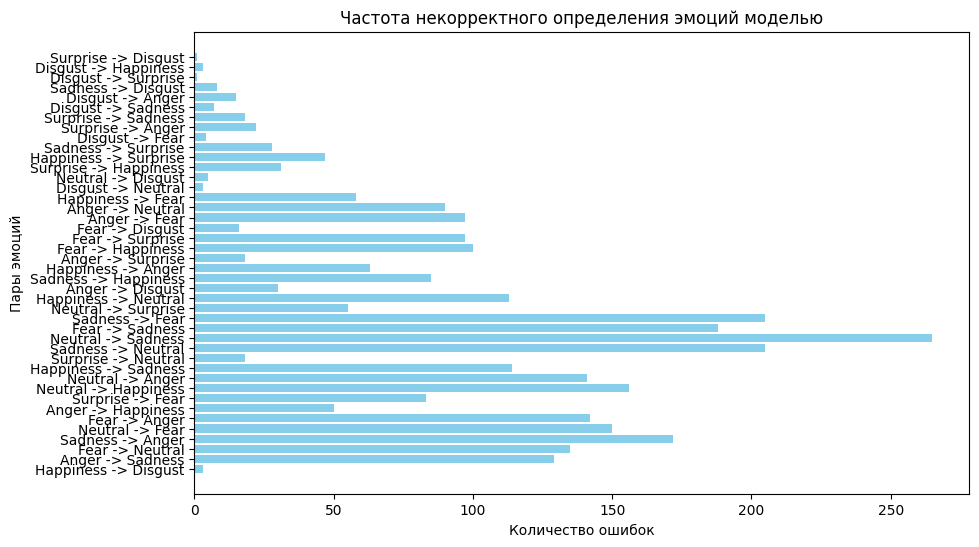

In [ ]:
confusion_diagramm(confusion_count(deepface_emotions, actual))

# Real time video

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX

while True:
    ret, frame = cap.read()
    result = DeepFace.analyze(frame, actions = ['emotion'], enforce_detection = False)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    X, Y = 50, 50
    for(x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (135, 206, 250), 2)
        X = x + 10
        Y = y - 5
    cv2.putText(frame, result[0]['dominant_emotion'], (X, Y), font, 1, (135, 206, 250), 2, cv2.LINE_4)
    cv2.imshow('Real time video', frame)
    if cv2.waitKey(10) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Точность модели FER

In [ ]:
word_map = {
     'happy': 'Happiness',
     'angry': 'Anger',
     'sad': 'Sadness',
     'fear': 'Fear',
     'neutral': 'Neutral',
     'surprise': 'Surprise',
     'disgust': 'Disgust'
}

In [ ]:
emotion_detector = FER(mtcnn=True)

In [ ]:
prediction = []
start_time = time.time()
for img in face_img_list:
  dominant_emotion, emotion_score = emotion_detector.top_emotion(img)
  prediction.append(dominant_emotion)
end_time = time.time()
execution_time = end_time - start_time
result['FER_mtcnn'] = {}
result['FER_mtcnn']['time'] = execution_time

Время выполнения: 412.35258293151855 секунд
Accuracy: 39.509612705489


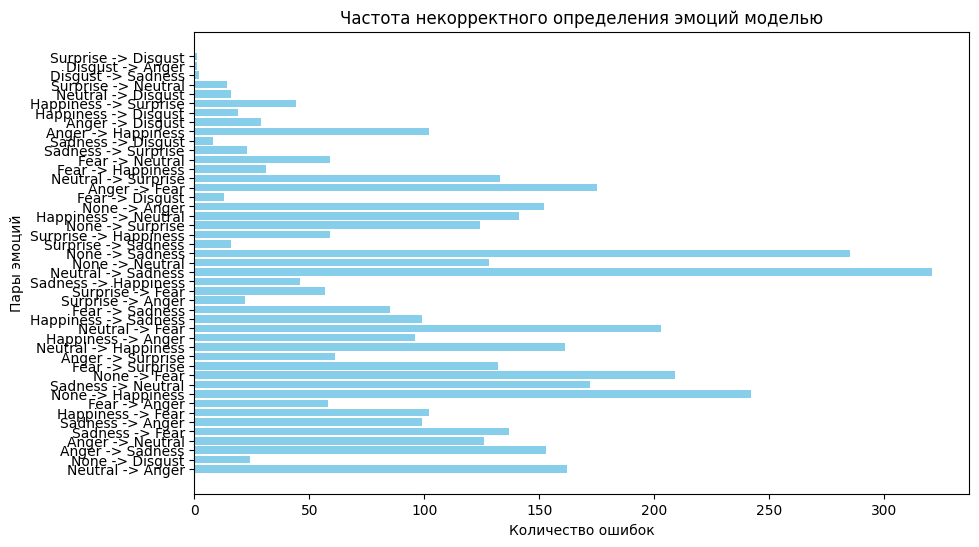

In [ ]:
prediction = [word_map.get(word, word) for word in prediction]
accuracy = calculate_accuracy(prediction, actual)
result['FER_mtcnn']['accuracy'] = accuracy
print(f"Время выполнения: {execution_time} секунд")
print(f"Accuracy: {accuracy}")
confusion_diagramm(confusion_count(prediction, actual))

In [ ]:
emotion_detector = FER(mtcnn=False)

In [ ]:
prediction = []
start_time = time.time()
for img in face_img_list:
  dominant_emotion, emotion_score = emotion_detector.top_emotion(img)
  prediction.append(dominant_emotion)
end_time = time.time()
execution_time = end_time - start_time
result['FER_Haar_Cascade'] = {}
result['FER_Haar_Cascade']['time'] = execution_time


Время выполнения: 0.6997311115264893 секунд
Accuracy: 0.0


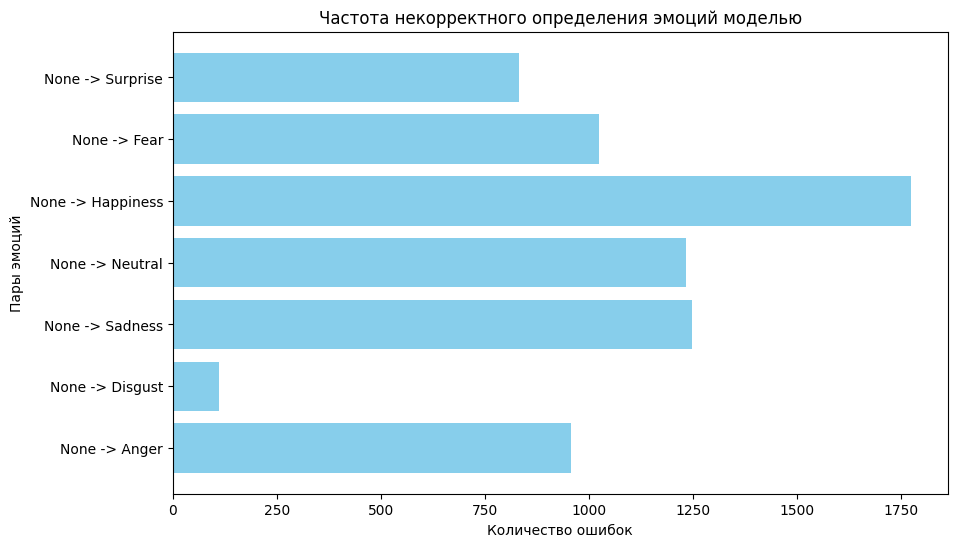

In [ ]:
prediction = [word_map.get(word, word) for word in prediction]
accuracy = calculate_accuracy(prediction, actual)
result['FER_Haar_Cascade']['accuracy'] = accuracy
print(f"Время выполнения: {execution_time} секунд")
print(f"Accuracy: {accuracy}")
confusion_diagramm(confusion_count(prediction, actual))

# Второй датасет HSEmotion

In [ ]:
dataset = ImageFolder('dataset')

In [ ]:
def transform_img(img):
    gray_image = img.convert('L')
    resized_image = gray_image.resize((48, 48))
    return np.array(resized_image)

In [ ]:
emotions_list = [img[1] for img in dataset]
img_list = [np.array(img[0]) for img in dataset]

In [ ]:
word_map = {
     4: 'Happiness',
     0: 'Anger',
     1: 'Contempt',
     6: 'Sadness',
     3: 'Fear',
     5: 'Neutral',
     7: 'Surprise',
     2: 'Disgust'
}

In [ ]:
emotions_list = [word_map.get(word, word) for word in emotions_list]

/root/.hsemotion/enet_b2_7.pt Compose(
    Resize(size=(260, 260), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
enet_b2_7
Время выполнения: 219.99850368499756 секунд
Accuracy: 62.1266642677222


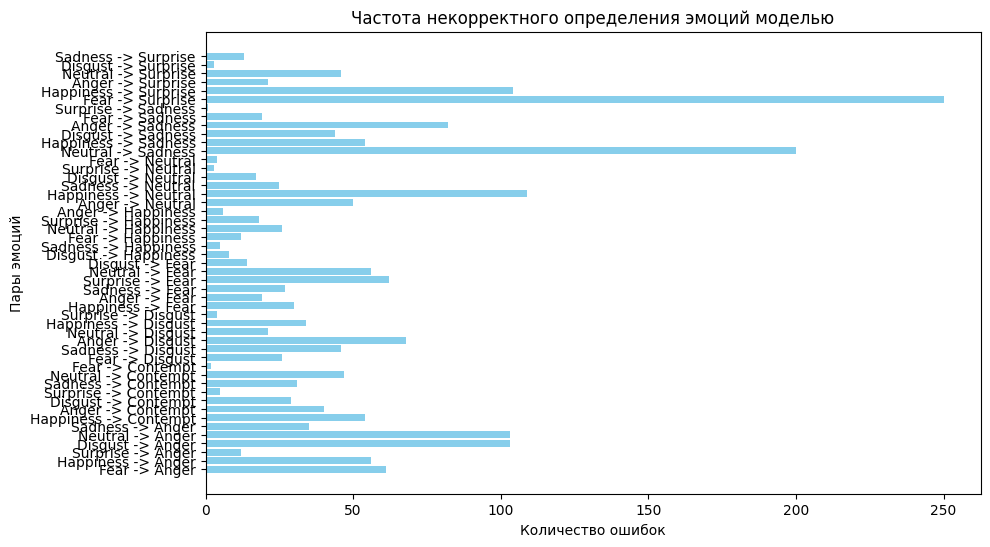

/root/.hsemotion/enet_b0_8_best_vgaf.pt Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
enet_b0_8_best_vgaf
Время выполнения: 152.37422966957092 секунд
Accuracy: 61.370996761424976


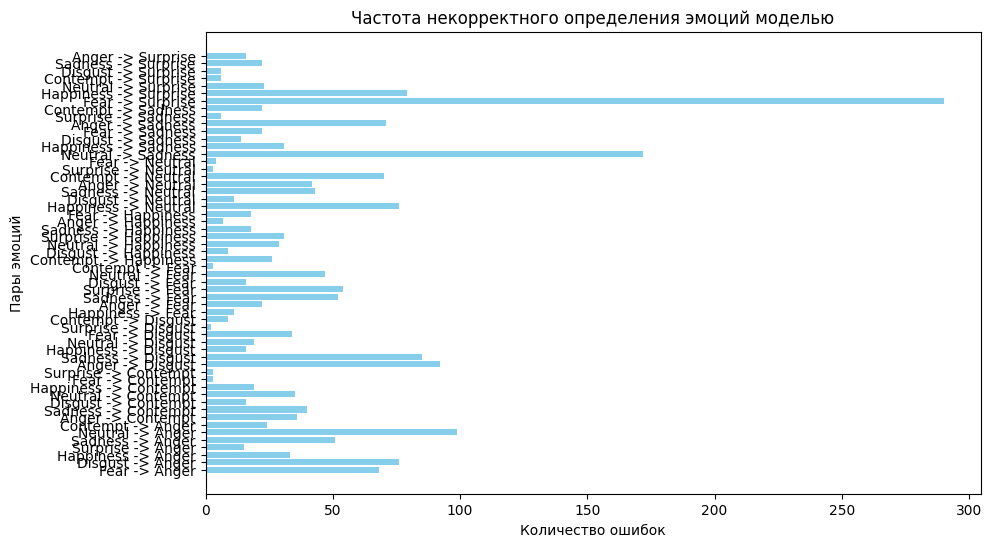

/root/.hsemotion/enet_b0_8_best_afew.pt Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
enet_b0_8_best_afew
Время выполнения: 163.37572717666626 секунд
Accuracy: 59.751709247930904


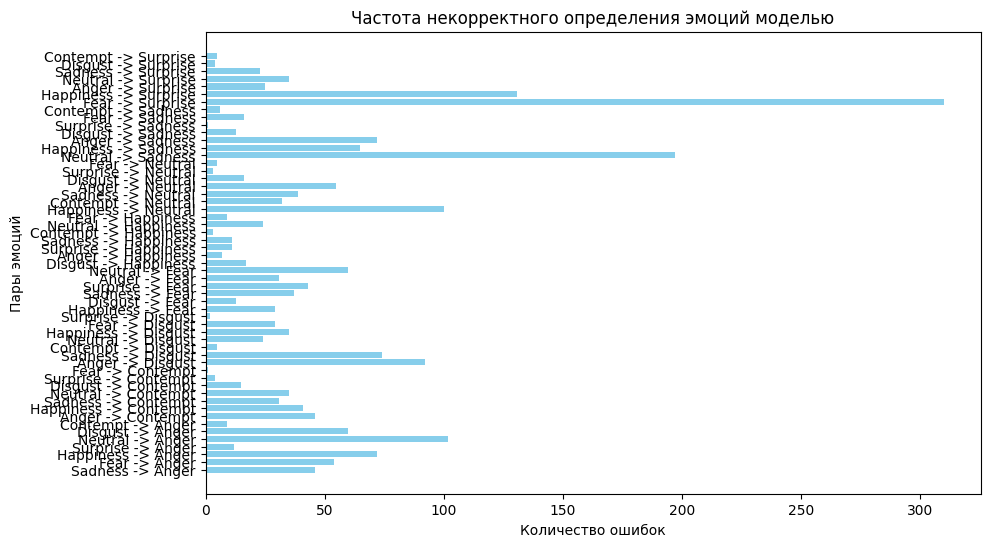

In [ ]:
for model in models:
    fer=HSEmotionRecognizer(model_name=model, device=device)
    prediction = []
    start_time = time.time()
    for i in range(len(img_list)):
        emotion,scores=fer.predict_emotions(img_list[i],logits=True)
        prediction.append(emotion)
    end_time = time.time()
    execution_time = end_time - start_time
    result[model+'_second'] = {}
    result[model+'_second']['time'] = execution_time
    accuracy = calculate_accuracy(prediction, emotions_list)
    result[model+'_second']['accuracy'] = accuracy
    print(model)
    print(f"Время выполнения: {execution_time} секунд")
    print(f"Accuracy: {accuracy}")
    confusion_diagramm(confusion_count(prediction, emotions_list))

# Второй датасет DeepFace

In [ ]:
result['deepFace_second'] = {}

In [ ]:
deepface_emotions = []
start_time = time.time()
for i in range(len(img_list)):
    img = img_list[i]
    demography = DeepFace.analyze(img_path = img, enforce_detection = False, actions=['emotion'])
    deepface_emotions.append(demography[0]['dominant_emotion'])
end_time = time.time()
execution_time = end_time - start_time
result['deepFace_second']['time'] = execution_time
print("Время выполнения: %s секунд" % execution_time)

Время выполнения: 643.6821625232697 секунд


In [ ]:
word_map = {
    'happy': 'Happiness',
    'angry': 'Anger',
    'sad': 'Sadness',
    'fear': 'Fear',
    'neutral': 'Neutral',
    'surprise': 'Surprise',
    'disgust': 'Disgust'
}

In [ ]:
deepface_emotions = [word_map.get(word, word) for word in deepface_emotions]

In [ ]:
deepface_emotions = [word_map.get(word, word) for word in deepface_emotions]
result['deepFace_second']['accuracy'] = calculate_accuracy(deepface_emotions, emotions_list)
result['deepFace_second']['accuracy']

41.95753868297949

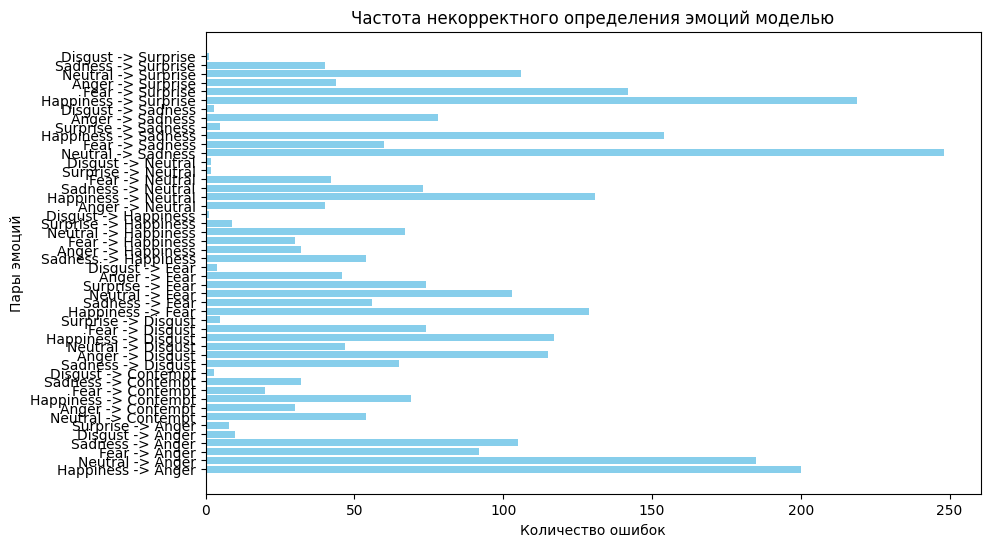

In [ ]:
confusion_diagramm(confusion_count(deepface_emotions, emotions_list))

# Второй датасет FER

In [ ]:
word_map = {
     'happy': 'Happiness',
     'angry': 'Anger',
     'sad': 'Sadness',
     'fear': 'Fear',
     'neutral': 'Neutral',
     'surprise': 'Surprise',
     'disgust': 'Disgust'
}

In [ ]:
emotion_detector = FER(mtcnn=True)

Время выполнения: 493.4796950817108 секунд
Accuracy: 15.599136379992803


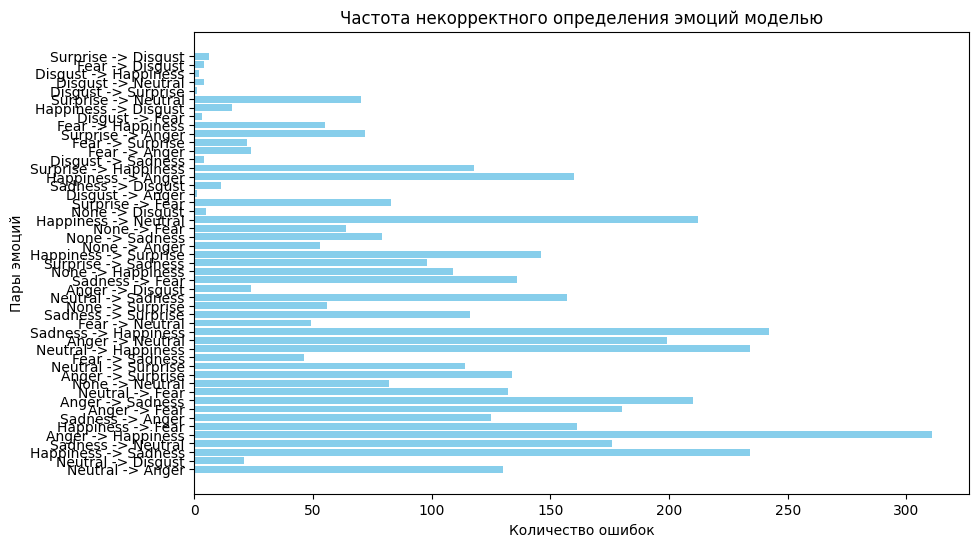

In [ ]:
prediction = []
start_time = time.time()
for i in range(len(img_list)):
  img = img_list[i]
  dominant_emotion, emotion_score = emotion_detector.top_emotion(img)
  prediction.append(dominant_emotion)
end_time = time.time()
execution_time = end_time - start_time
result['FER_mtcnn_second'] = {}
result['FER_mtcnn_second']['time'] = execution_time
prediction = [word_map.get(word, word) for word in prediction]
accuracy = calculate_accuracy(prediction, actual)
result['FER_mtcnn_second']['accuracy'] = accuracy
print(f"Время выполнения: {execution_time} секунд")
print(f"Accuracy: {accuracy}")
confusion_diagramm(confusion_count(prediction, actual))

In [ ]:
emotion_detector = FER(mtcnn=False)

Время выполнения: 170.8110647201538 секунд
Accuracy: 5.343648794530407


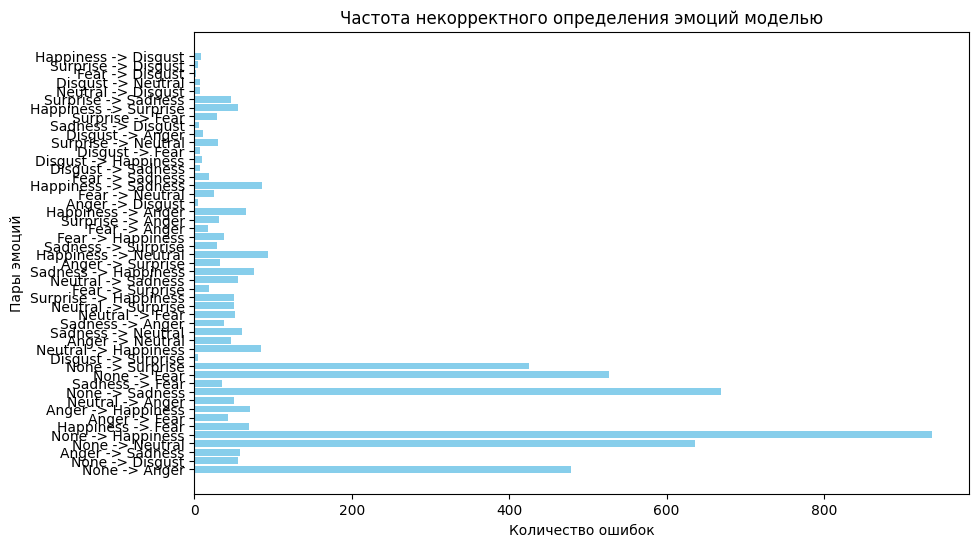

In [ ]:
prediction = []
start_time = time.time()
for i in range(len(img_list)):
  img = img_list[i]
  dominant_emotion, emotion_score = emotion_detector.top_emotion(img)
  prediction.append(dominant_emotion)
end_time = time.time()
execution_time = end_time - start_time
result['FER_Haar_Cascade_second'] = {}
result['FER_Haar_Cascade_second']['time'] = execution_time
prediction = [word_map.get(word, word) for word in prediction]
accuracy = calculate_accuracy(prediction, actual)
result['FER_Haar_Cascade_second']['accuracy'] = accuracy
print(f"Время выполнения: {execution_time} секунд")
print(f"Accuracy: {accuracy}")
confusion_diagramm(confusion_count(prediction, actual))

# Результаты

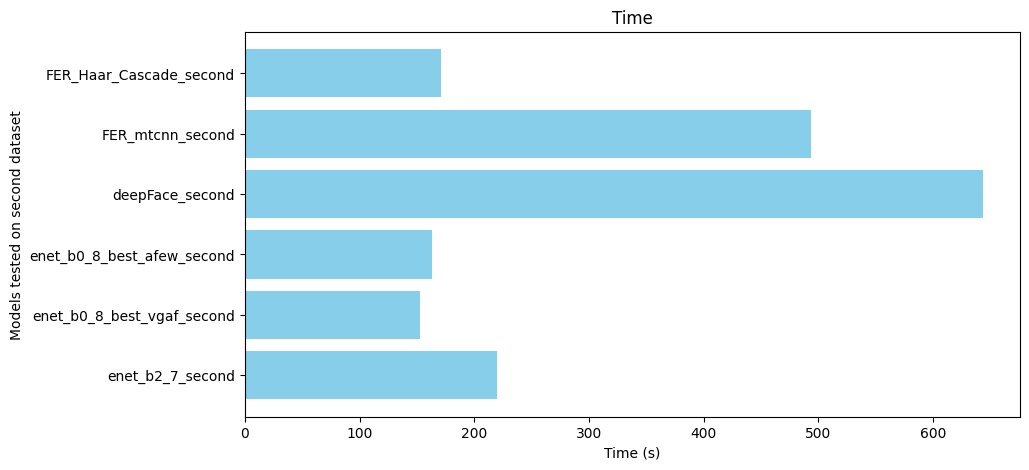

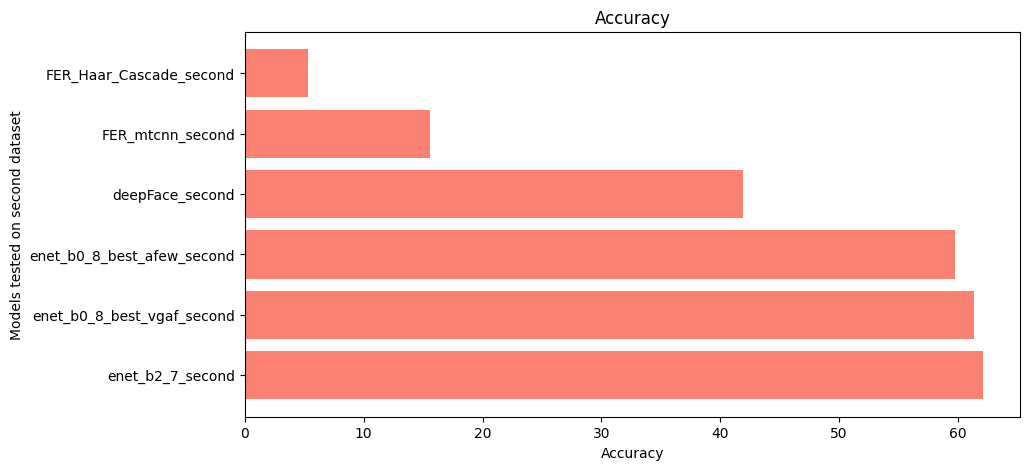

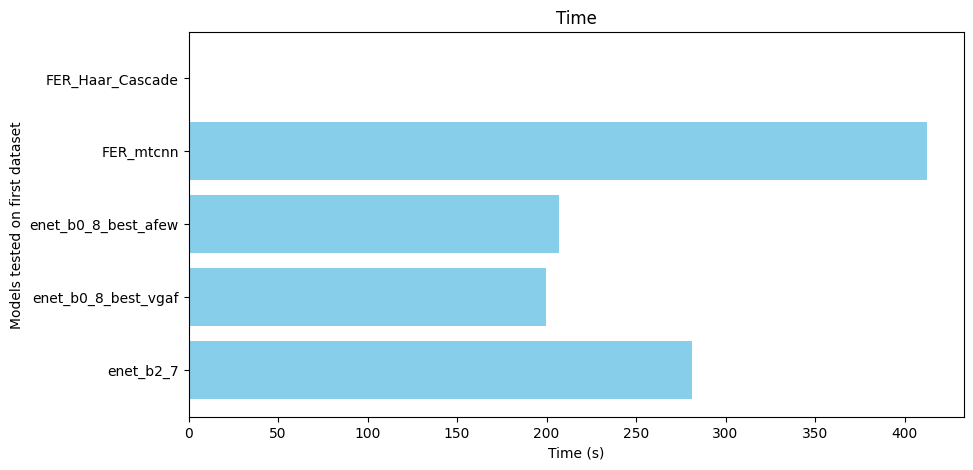

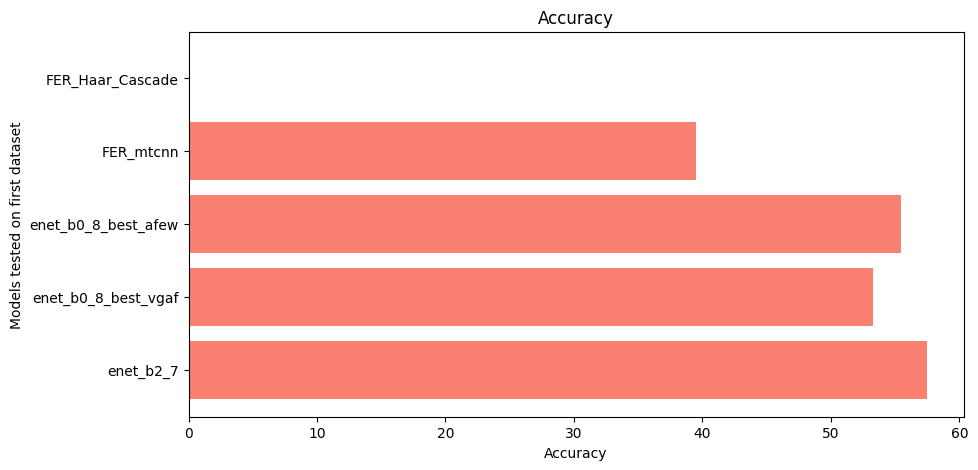

In [ ]:
models_with_second = []
times_with_second = []
accuracies_with_second = []

models_without_second = []
times_without_second = []
accuracies_without_second = []

for model, data in result.items():
    if 'second' in model:
        models_with_second.append(model)
        times_with_second.append(data['time'])
        accuracies_with_second.append(data['accuracy'])
    else:
        models_without_second.append(model)
        times_without_second.append(data['time'])
        accuracies_without_second.append(data['accuracy'])

plt.figure(figsize=(10, 5))
plt.barh(models_with_second, times_with_second, color='skyblue')
plt.xlabel('Time (s)')
plt.ylabel('Models tested on second dataset')
plt.title('Time')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(models_with_second, accuracies_with_second, color='salmon')
plt.xlabel('Accuracy')
plt.ylabel('Models tested on second dataset')
plt.title('Accuracy')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(models_without_second, times_without_second, color='skyblue')
plt.xlabel('Time (s)')
plt.ylabel('Models tested on first dataset')
plt.title('Time')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(models_without_second, accuracies_without_second, color='salmon')
plt.xlabel('Accuracy')
plt.ylabel('Models tested on first dataset')
plt.title('Accuracy')
plt.show()